<a href="https://colab.research.google.com/github/Earthlink44/EM-algorithm/blob/master/EM_Multivariate_T_distribution.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1. Multivariate T-distribution with known $\nu$

we want to maximize complete log likelihood

>$$\mathcal{l}_{c} = L_{N}(\mathbf{\mu},\mathbf{\Sigma})+L_{G}(\nu)$$ 


>$$ L_{N}(\mathbf{\mu},\mathbf{\Sigma}) = -\frac{1}{2}N\log(\mathbf{\Sigma}) - \frac{1}{2}\sum^{N}_{i=1}z_{i}\delta_{i} $$

>$$ L_{G}(\nu) = -N\log\Gamma(\nu/2) + \frac{1}{2}N\nu\log(\nu/2) +\frac{1}{2}\nu\sum_{i=1}^{N}(\log{z_i}-z_i) $$


Initialize parameters $\mathbf{\theta} = (\mathbf{\mu},\mathbf{\Sigma},\nu)$

$\mathbf{\mu}^{0}$ as sample mean

$\mathbf{\Sigma}^{0}$ as sample covariance

$\delta_{i}^{(0)} = (\mathbf{x_i}-\mathbf{\mu^{(0)}})^{T}(\mathbf{\sum^{(0)})^{-1}}(\mathbf{x_i}-\mathbf{\mu^{(0)}})$ mahalanobis distance

$\bar{z}^{(0)}_{i} =\mathbb{E}\left[{z_i}|\mathbf{x}_{i},\mathbf{\theta}^{(0)}\right] = \frac{\nu^{(0)}+D}{\nu^{(0)}+\delta^{(0)}_{i}}$

repeat until $\mathcal{l}_{c}^{t} - \mathcal{l}_{c}^{t-1} < \varepsilon$

## 1. E-step 

>$$\bar{z}^{(t)}_{i} = \frac{\nu^{(t)}+D}{\nu^{(t)}+\delta^{(t)}_{i}}$$ where $\delta_{i}^{(t)} = (\mathbf{x_i}-\mathbf{\mu^{(t)}})^{T}(\mathbf{\sum^{(t)})^{-1}}(\mathbf{x_i}-\mathbf{\mu^{(t)}})$ is Mahalanobis distance

## 2. M-step

>$$\mathbf{\hat{\mu}}^{(t+1)}=\frac{ \sum_{i}\bar{z}^{(t)}_{i}\mathbf{x}_i }
{ \sum_{i}\bar{z}^{(t)}_{i} } $$

>\
\begin{aligned}
\hat{\Sigma}^{(t+1)} 
&=\frac{1}{N}\sum_i\bar{z}^{(t)}_{i}(\mathbf{x}_{i}-\mathbf{\hat{\mu}}^{(t+1)})(\mathbf{x}_{i}-\mathbf{\hat{\mu}}^{(t+1)})^{T}  \\
&=\frac{1}{N}\left[\sum_{i}\bar{z}^{(t)}_{i}\mathbf{x}_{i}\mathbf{x}_{i}^{T}-\left(\sum_{i=1}^{N}\bar{z}^{(t)}_{i}\right)\mathbf{\hat{\mu}}^{(t+1)}\mathbf({\hat{\mu}}^{(t+1)})^{T}\right] 
\end{aligned}


from the book 'Machine Learning A Probabilistic Perspective' by Kevin P. Murphy (page 359 section 11.4.5)

link: https://drive.google.com/file/d/116vH53XhO16BFnLELpzBoPoRBWeUVAV4/view?usp=sharing

In [400]:
import numpy as np
from scipy import special

def fitmvtfixnu(X,dof, iter = 200, eps = 1e-6):
  '''
  Input 
  1. X - Data with matrix of dimension (D,N) where D is Dimension and N is Sample size (D must >= 2)
  2. dof - Degree of freedom
  3. iter - Maximum iteration 
  4. eps - torelance
  Output
  1. Cov - Covariance matrix
  2. mean - mean value vector for each dimension
  3. obj - history of Loglikihood function
  '''
  # Initialize parameters
  D = X.shape[1];
  N = X.shape[0];
  cov = np.cov(X,rowvar=False); # Calculate covariance matrix where row is observations (shape = (D,D))
  mean = X.mean(axis=0); # Calculate the mean vector (shape = (1,D))
  mu = X - mean[None,:]; # (X-mean(X)) demean the data
  delta = (mu * (np.linalg.inv(cov) @ mu.T).T).sum(axis=1); # Mahalanobis distance
  z = (dof + D) / (dof + delta);
  Loglike = [
        (
        -N*np.linalg.slogdet(cov)[1]/2 - (z*delta).sum()/2 
        -N*special.gammaln(dof/2) + N*dof*np.log(dof/2)/2 + dof*(np.log(z)-z).sum()/2
        )
  ];
  # iterate
  for i in range(iter):
    # M step
    mean = (X * z[:,None]).sum(axis=0).reshape(-1,1) / z.sum();
    mu = X - mean.squeeze()[None,:]; # Demean Data
    cov = (mu.T @ (mu * z[:,None]))/N; # Covariance matrix

    # E step
    delta = (mu * (np.linalg.inv(cov) @ mu.T).T).sum(axis=1); # Mahalanobis distance
    z = (dof + D) / (dof + delta);

    Loglike.append(
            (
            -N*np.linalg.slogdet(cov)[1]/2 - (z*delta).sum()/2 
            -N*special.gammaln(dof/2) + N*dof*np.log(dof/2)/2 + dof*(np.log(z)-z).sum()/2
            )
    );    
    if np.abs(Loglike[-1] - Loglike[-2]) < eps:
            break
  return cov, mean.squeeze(), Loglike

# 2. Multivariate T-distribution with unknown $\nu$
Initialize parameters $\mathbf{\theta} = (\mathbf{\mu},\mathbf{\Sigma},\nu)$

we want to maximize complete log likelihood

>$$\mathcal{l}_{c} = L_{N}(\mathbf{\mu},\mathbf{\Sigma})+L_{G}(\nu)$$ 


>$$ L_{N}(\mathbf{\mu},\mathbf{\Sigma}) = -\frac{1}{2}N\log(\mathbf{\Sigma}) - \frac{1}{2}\sum^{N}_{i=1}z_{i}\delta_{i} $$

>$$ L_{G}(\nu) = -N\log\Gamma(\nu/2) + \frac{1}{2}N\nu\log(\nu/2) +\frac{1}{2}\nu\sum_{i=1}^{N}(\log{z_i}-z_i) $$

$\mathbf{\mu}^{0}$ as sample mean

$\mathbf{\Sigma}^{0}$ as sample covariance

$\delta_{i}^{(0)} = (\mathbf{x_i}-\mathbf{\mu^{(0)}})^{T}(\mathbf{\sum^{(0)})^{-1}}(\mathbf{x_i}-\mathbf{\mu^{(0)}})$ mahalanobis distance

$\bar{z}^{(0)}_{i} =\mathbb{E}\left[{z_i}|\mathbf{x}_{i},\mathbf{\theta}^{(0)}\right] = \frac{\nu^{(0)}+D}{\nu^{(0)}+\delta^{(0)}_{i}}$

$ \overline{\log{z}}^{(0)}_{i}
= \mathbb{E}\left[\log{z_i}|\mathbf{\theta}^{(0)}\right]
= \log(\bar{z}^{(0)}_{i}) + \Psi(\frac{\nu^{(0)}+D}{2}) - \log(\frac{\nu^{(0)}+D}{2})
$

repeat until $\mathcal{l}_{c}^{t} - \mathcal{l}_{c}^{t-1} < \varepsilon$

## 1. E-step 

>\
\begin{aligned}
\bar{z}^{(t)}_{i} 
&= \mathbb{E}\left[{z_i}|\mathbf{x}_{i},\mathbf{\theta}^{(t)}\right] \\
&= \frac{\nu^{(t)}+D}{\nu^{(t)}+\delta^{(t)}_{i}}
\end{aligned}

where $\delta_{i}^{(t)} = (\mathbf{x_i}-\mathbf{\mu^{(t)}})^{T}(\mathbf{\sum^{(t)})^{-1}}(\mathbf{x_i}-\mathbf{\mu^{(t)}})$ is Mahalanobis distance

>\
\begin{aligned}
\overline{\log{z}}^{(t)}_{i} 
&= \mathbb{E}\left[\log{z_i}|\mathbf{\theta}^{(t)}\right] \\
&= \Psi(\frac{\nu^{(t)}+D}{2}) - \log(\frac{\nu^{(t)}+\delta_{i}^{(t)}}{2}) \\
&= \log(\bar{z}^{(t)}_{i}) + \Psi(\frac{\nu^{(t)}+D}{2}) - \log(\frac{\nu^{(t)}+D}{2}) \\
\end{aligned}

## 2. M-step

>$$\mathbf{\hat{\mu}}^{(t+1)}=\frac{ \sum_{i}\bar{z}^{(t)}_{i}\mathbf{x}_i }
{ \sum_{i}\bar{z}^{(t)}_{i} } $$

>\
\begin{aligned}
\hat{\Sigma}^{(t+1)} 
&=\frac{1}{N}\sum_i\bar{z}^{(t)}_{i}(\mathbf{x}_{i}-\mathbf{\hat{\mu}}^{(t+1)})(\mathbf{x}_{i}-\mathbf{\hat{\mu}}^{(t+1)})^{T}  \\
&=\frac{1}{N}\left[\sum_{i}\bar{z}^{(t)}_{i}\mathbf{x}_{i}\mathbf{x}_{i}^{T}-\left(\sum_{i=1}^{N}\bar{z}^{(t)}_{i}\right)\mathbf{\hat{\mu}}^{(t+1)}\mathbf({\hat{\mu}}^{(t+1)})^{T}\right] 
\end{aligned}

then $\nu^{(t)}$ can be calculated by numerically solving the following equation

>$$-\frac{N}{2}\Psi(\nu/2) + \frac{N}{2}\log{(v/2)} + \frac{N}{2} + \frac{1}{2}\sum_{i}\left(\overline{\log{z}}^{(t)}_{i} - \bar{z}^{(t)}_{i} \right) = 0$$


from the book 'Machine Learning A Probabilistic Perspective' by Kevin P. Murphy (page 359 section 11.4.5)

link: https://drive.google.com/file/d/116vH53XhO16BFnLELpzBoPoRBWeUVAV4/view?usp=sharing

In [413]:
import numpy as np
from scipy import special, optimize

def fitmvt(X,dof = 0.01, iter = 200, eps = 1e-6):
  '''
  Input 
  1. X - Data with matrix of dimension (D,N) where D is Dimension and N is Sample size (D must >= 2)
  2. dof - Degree of freedom
  3. iter - Maximum iteration 
  4. eps - torelance
  Output
  1. Cov - Covariance matrix
  2. mean - mean value vector for each dimension
  3. dof - Estimated degree of freedom
  4. obj - history of Loglikihood function
  '''
  # Initialize parameters
  D = X.shape[1];
  N = X.shape[0];
  cov = np.cov(X,rowvar=False); # Calculate covariance matrix where row is observations (shape = (D,D))
  mean = X.mean(axis=0); # Calculate the mean vector (shape = (1,D))
  mu = X - mean[None,:]; # (X-mean(X)) demean the data
  delta = (mu * (np.linalg.inv(cov) @ mu.T).T).sum(axis=1); # Mahalanobis distance
  z = (dof + D) / (dof + delta);
  logz = np.log(z) + special.digamma((dof+D)/2) - np.log((dof+D)/2);

  Loglike = [
        (
        -N*np.linalg.slogdet(cov)[1]/2 - (z*delta).sum()/2 
        -N*special.gammaln(dof/2) + N*dof*np.log(dof/2)/2 + dof*(logz-z).sum()/2
        )
  ];
  # iterate
  for i in range(iter):
    # M step
    mean = (X * z[:,None]).sum(axis=0).reshape(-1,1) / z.sum();
    mu = X - mean.squeeze()[None,:]; # Demean Data
    cov = (mu.T @ (mu * z[:,None]))/N; # Covariance matrix
    dof = optimize.fsolve(lambda x: - N*special.digamma(x/2)/2 + N*np.log(x/2)/2 + N/2 + 0.5*(logz-z).sum() ,x0=dof);

    # E step
    delta = (mu * (np.linalg.inv(cov) @ mu.T).T).sum(axis=1); # Mahalanobis distance
    z = (dof + D) / (dof + delta);
    logz = np.log(z) + special.digamma((dof+D)/2) - np.log((dof+D)/2);

    Loglike.append(
            (
            -N*np.linalg.slogdet(cov)[1]/2 - (z*delta).sum()/2 
            -N*special.gammaln(dof/2) + N*dof*np.log(dof/2)/2 + dof*(logz-z).sum()/2
            )
    );    
    if np.abs(Loglike[-1] - Loglike[-2]) < eps:
            break
  return cov, mean.squeeze(), dof, Loglike

# Multivariate T distribution random (From Enzo Michelangeli)

In [414]:
#written by Enzo Michelangeli, style changes by josef-pktd
# Student's T random variable
def multivariate_t_rvs(m, S, df=np.inf, n=1):
    '''generate random variables of multivariate t distribution
    Parameters
    ----------
    m : array_like
        mean of random variable, length determines dimension of random variable
    S : array_like
        square array of covariance  matrix
    df : int or float
        degrees of freedom
    n : int
        number of observations, return random array will be (n, len(m))
    Returns
    -------
    rvs : ndarray, (n, len(m))
        each row is an independent draw of a multivariate t distributed
        random variable
    '''
    m = np.asarray(m)
    d = len(m)
    if df == np.inf:
        x = 1.
    else:
        x = np.random.chisquare(df, n)/df
    z = np.random.multivariate_normal(np.zeros(d),S,(n,))
    return m + z/np.sqrt(x)[:,None]   # same output format as random.multivariate_normal

# Try it yourself!

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import time

In [415]:
D = 5
X = multivariate_t_rvs(
    
    np.ones(D),

    np.eye(D),

    df=2.5,
    
    n=1000
    )

In [416]:
cov, mu, logl = fitmvtfixnu(X,dof=2.5)

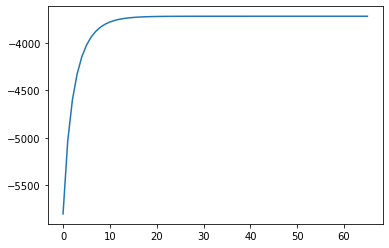

In [412]:
plt.plot(logl)

In [ ]:
nu

array([2.47317458])

## Compare between np.einsum and np.dot for Mahalanobis distance calculation

$$\delta_{i}^{(t)} = (\mathbf{x_i}-\mathbf{\mu^{(t)}})^{T}(\mathbf{\Sigma^{(t)})^{-1}}(\mathbf{x_i}-\mathbf{\mu^{(t)}})$$ 

In [ ]:
# parameters for test purpose
dof = 200 
i = 500

In [ ]:
D = 300
X = multivariate_t_rvs(
    
    np.ones(D),

    np.eye(D),

    df=2.5,
    
    n=10000
    )

In [ ]:
# einsum
delta = np.einsum('ij,ij->i', mu, np.linalg.solve(cov,mu.T).T)

In [ ]:
# np.dot
delta = (mu * (np.linalg.inv(cov) @ mu.T).T).sum(axis=1)

In [ ]:
timematein = []
for i in range(i):
  tic = time.time()
  delta = np.einsum('ij,ij->i', mu, np.linalg.solve(cov,mu.T).T)
  toc = time.time()
  timematein.append(toc-tic)

In [ ]:
timematad = []
for i in range(i):
  tic = time.time()
  delta = (mu * (np.linalg.inv(cov) @ mu.T).T).sum(axis=1)
  toc = time.time()
  timematad.append(toc-tic)

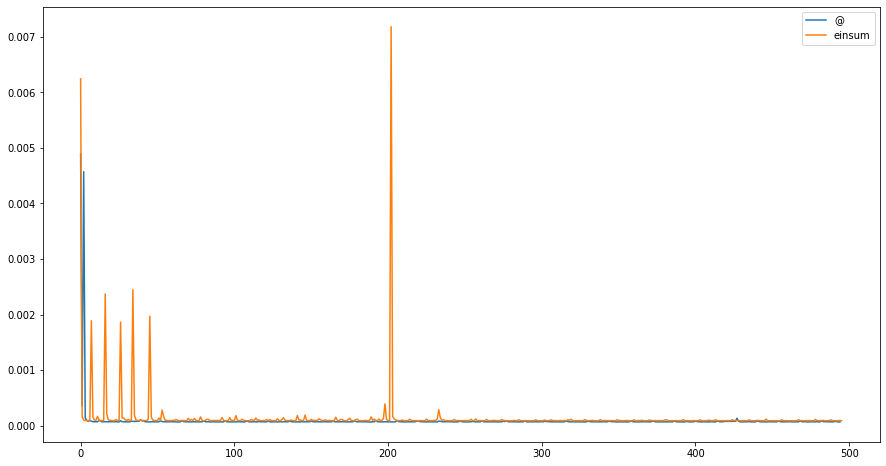

In [ ]:
plt.figure(figsize=(15,8))
plt.plot(timematad,label='@')
plt.plot(timematein,label='einsum')
plt.legend()

## compare between einsum and np.dot to compute Covariance matrix in loop

$$\hat{\Sigma}^{(t+1)} 
=\frac{1}{N}\sum_i\bar{z}^{(t)}_{i}(\mathbf{x}_{i}-\mathbf{\hat{\mu}}^{(t+1)})(\mathbf{x}_{i}-\mathbf{\hat{\mu}}^{(t+1)})^{T}$$

In [ ]:
# parameters for test purpose
dof = 3 
i = 500

In [ ]:
D = 50
X = multivariate_t_rvs(
    
    np.ones(D),

    np.eye(D),

    df=2.5,
    
    n=10000
    )

In [ ]:
D = X.shape[1];
N = X.shape[0];
cov = np.cov(X,rowvar=False); # Calculate covariance matrix where row is observations (shape = (D,D))
mean = X.mean(axis=0); # Calculate the mean vector (shape = (1,D))
mu = X - mean[None,:]; # (X-mean(X)) demean the data
delta = (mu * (np.linalg.inv(cov) @ mu.T).T).sum(axis=1); # Mahalanobis distance
z = (dof + D) / (dof + delta);
Loglike = [
      -N*np.linalg.slogdet(cov)[1]/2 - (z*delta).sum()/2 
      -N*special.gammaln(dof/2) + N*dof*np.log(dof/2)/2 + dof*(np.log(z)-z).sum()/2
];

mean = (X * z[:,None]).sum(axis=0).reshape(-1,1) / z.sum();
mu = X - mean.squeeze()[None,:];

In [ ]:
# einsum
cov = np.einsum('ij,ik->jk', mu, mu * z[:,None])/N;
cov

array([[ 3.34146654e+00, -1.36009066e-02,  6.41702197e-04, ...,
         9.20863332e-03,  7.63744627e-03,  4.88626739e-02],
       [-1.36009066e-02,  3.41646798e+00,  4.80099314e-03, ...,
        -1.20674611e-03,  6.74778741e-03, -1.73548284e-02],
       [ 6.41702197e-04,  4.80099314e-03,  3.43483382e+00, ...,
         5.84928246e-02, -8.48898689e-03,  1.95569628e-02],
       ...,
       [ 9.20863332e-03, -1.20674611e-03,  5.84928246e-02, ...,
         3.33378728e+00,  3.25983492e-03, -4.18904574e-02],
       [ 7.63744627e-03,  6.74778741e-03, -8.48898689e-03, ...,
         3.25983492e-03,  3.36585948e+00,  7.85770908e-03],
       [ 4.88626739e-02, -1.73548284e-02,  1.95569628e-02, ...,
        -4.18904574e-02,  7.85770908e-03,  3.42331436e+00]])

In [ ]:
# np.dot
cov = (mu.T @ (mu * z[:,None]))/N;
cov

array([[ 3.34146654e+00, -1.36009066e-02,  6.41702197e-04, ...,
         9.20863332e-03,  7.63744627e-03,  4.88626739e-02],
       [-1.36009066e-02,  3.41646798e+00,  4.80099314e-03, ...,
        -1.20674611e-03,  6.74778741e-03, -1.73548284e-02],
       [ 6.41702197e-04,  4.80099314e-03,  3.43483382e+00, ...,
         5.84928246e-02, -8.48898689e-03,  1.95569628e-02],
       ...,
       [ 9.20863332e-03, -1.20674611e-03,  5.84928246e-02, ...,
         3.33378728e+00,  3.25983492e-03, -4.18904574e-02],
       [ 7.63744627e-03,  6.74778741e-03, -8.48898689e-03, ...,
         3.25983492e-03,  3.36585948e+00,  7.85770908e-03],
       [ 4.88626739e-02, -1.73548284e-02,  1.95569628e-02, ...,
        -4.18904574e-02,  7.85770908e-03,  3.42331436e+00]])

In [ ]:
timematein = []
for i in range(i):
  tic = time.time()
  cov = np.einsum('ij,ik->jk', mu, mu * z[:,None])/N
  toc = time.time()
  timematein.append(toc-tic)

In [ ]:
timematad = []
for i in range(i):
  tic = time.time()
  cov = (mu.T @ (mu * z[:,None]))/N;
  toc = time.time()
  timematad.append(toc-tic)

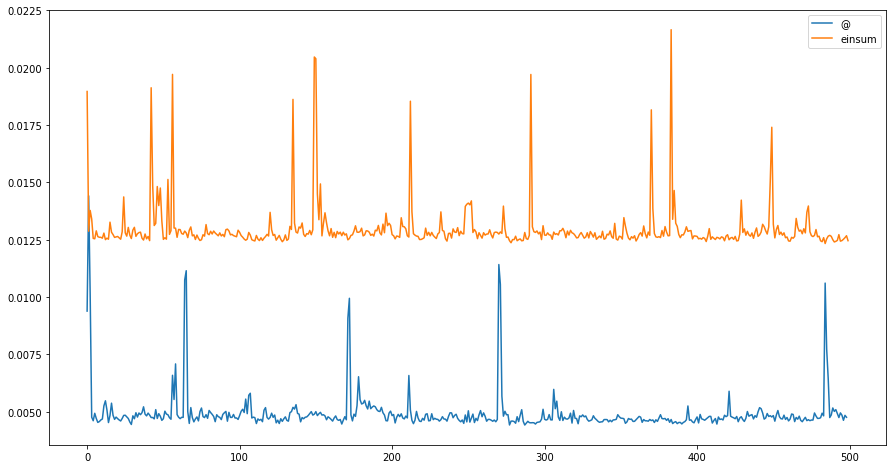

In [ ]:
plt.figure(figsize=(15,8))
plt.plot(timematad,label='@')
plt.plot(timematein,label='einsum')
plt.legend()